# BigMart Sales Prediction

## 1. Thư viện

In [112]:
import warnings
warnings.filterwarnings('ignore')  #tắt việc hiển thị các cảnh báo (warnings) trong quá trình thực thi chương trình

In [113]:
import pandas as pd  #xử lý dữ liệu dạng bảng (dataframe)
import numpy as np   #cung cấp nhiều hàm toán học và logic làm việc với mảng dữ liệu

import matplotlib.pyplot as plt #trực quan hóa, tạo các biểu đồ đồ thị, histogram, scatter plot
import seaborn as sns #trực quan hóa dữ liệu dựa trên Matplotlib
from scipy.stats import chi2_contingency #tính toán khoa học và toán học, sử dụng cho thống kê
from scipy.stats import f_oneway 
#ông cụ và thuật toán cho việc xử lý dữ liệu, huấn luyện mô hình, và đánh giá mô hình machine learning
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score # chia dữ liệu
from sklearn.preprocessing import LabelEncoder #chuyển đổi dữ liệu dạng chuỗi (categorical) sang dạng số (numerical)

## 2. Đọc dữ liệu

In [114]:
data = pd.read_csv("./Data/train_kOBLwZA.csv")
test_data = pd.read_csv("./Data/test_t02dQwI.csv")

## 3. Kiểm tra tập dữ liệu

In [115]:
data.head() #5 dòng đầu tiên của tập dữ liệu

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


tập dữ liệu bị thiếu các giá trị và các kiểu dữ liệu. Có thể thay đổi để phù hợp với mô hình hồi quy

In [117]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## 4. Tiền xử lý dữ liệu

### Gán item weight với giá trị tối đa của các item identifier khác nhau

In [118]:
data['Item_Weight'] = data['Item_Weight'].fillna(data.groupby('Item_Identifier')['Item_Weight'].transform('max'))

In [119]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Nhóm dữ liệu theo các giá trị trong cột "Item_Identifier" Chỉ định cột cần xử lý, tức là "Item_Weight". .transform('max'): Áp dụng hàm tính toán 'max' trên mỗi nhóm, tức là tìm giá trị lớn nhất của "Item_Weight" trong mỗi nhóm "Item_Identifier". Kết quả là một Series có cùng chiều dữ liệu với DataFrame gốc, nhưng thay vì giá trị lớn nhất của "Item_Weight" trong mỗi nhóm. => điền giá trị thiếu trong cột "Item_Weight" bằng giá trị lớn nhất của "Item_Weight" tương ứng với mỗi nhóm "Item_Identifier"

4 giá trị null có thể không có giá trị nào được tìm thấy trong mỗi nhóm để điền vào (là những trường hợp mà không có dữ liệu nào khác trong cùng nhóm "Item_Identifier" để tính toán giá trị lớn nhất của "Item_Weight". Điều này có thể xảy ra nếu tất cả các giá trị "Item_Weight" trong các nhóm tương ứng với các "Item_Identifier" đó đều là giá trị null hoặc không xác định.)

### Gán các giá trị còn thiếu trong outlet size bằng "Small"

In [120]:
data['Outlet_Size'] = data['Outlet_Size'].fillna("Small")

In [121]:
data.Outlet_Size.unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Xóa các dòng vẫn còn thiếu giá trị bằng cách chọn các hàng không có giá trị

In [123]:
df=data[data['Item_Weight'].notna()]

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                8519 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


### Giá trị được tính trong hàm lượng chất béo

In [125]:
df.Item_Fat_Content.value_counts()

Low Fat    5088
Regular    2886
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

### Thay thế các item thành 2 hình thức tiêu chuẩn

In [126]:
df.replace({'Item_Fat_Content':{'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)
df.Item_Fat_Content.value_counts()

Low Fat    5516
Regular    3003
Name: Item_Fat_Content, dtype: int64

In [127]:
df.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1199
Household                 910
Frozen Foods              855
Dairy                     681
Canned                    649
Baking Goods              647
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

### 5. EDA

#### 5.1. Biểu đồ countplot đếm số lượng các biến phân loại


<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

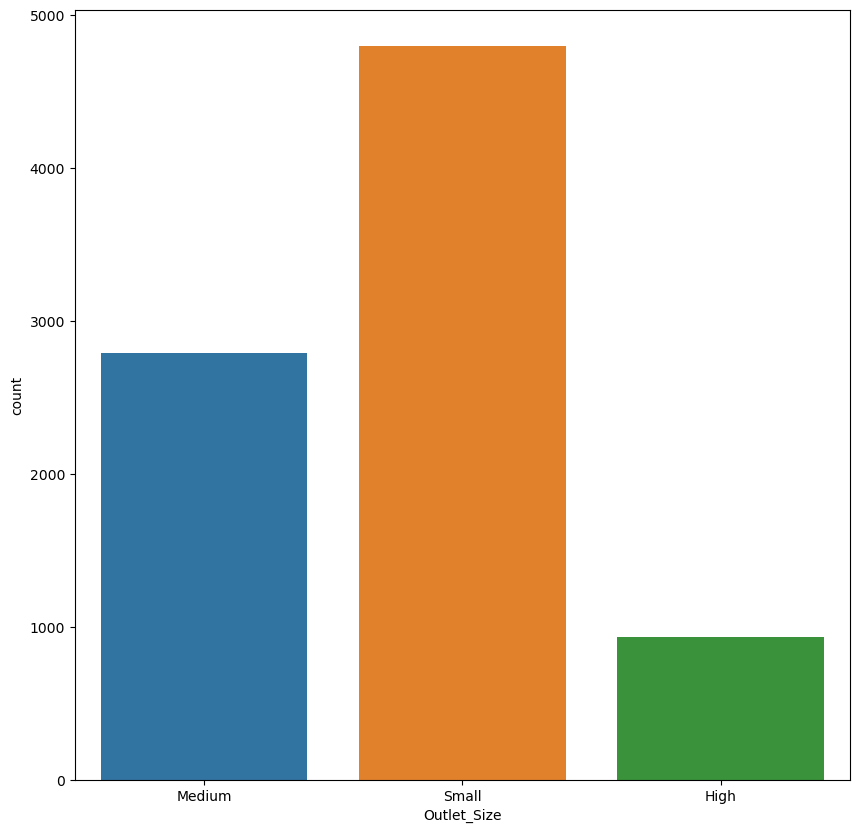

In [128]:
plt.figure(figsize=(10,10))
sns.countplot(x='Outlet_Size',data=df)

Đa số các cửa hàng trong tập dữ liệu có kích thước nhỏ: Điều này có thể phản ánh một thị trường mà các cửa hàng nhỏ lẻ chiếm ưu thế, hoặc có thể do chiến lược kinh doanh của công ty tập trung vào việc mở rộng mạng lưới cửa hàng nhỏ.
Số lượng cửa hàng trung bình và lớn tương đối ít: Có thể có nhiều yếu tố ảnh hưởng đến điều này, như vị trí địa lý, đối tượng khách hàng, hoặc chi phí vận hành.

<AxesSubplot:xlabel='Outlet_Type', ylabel='count'>

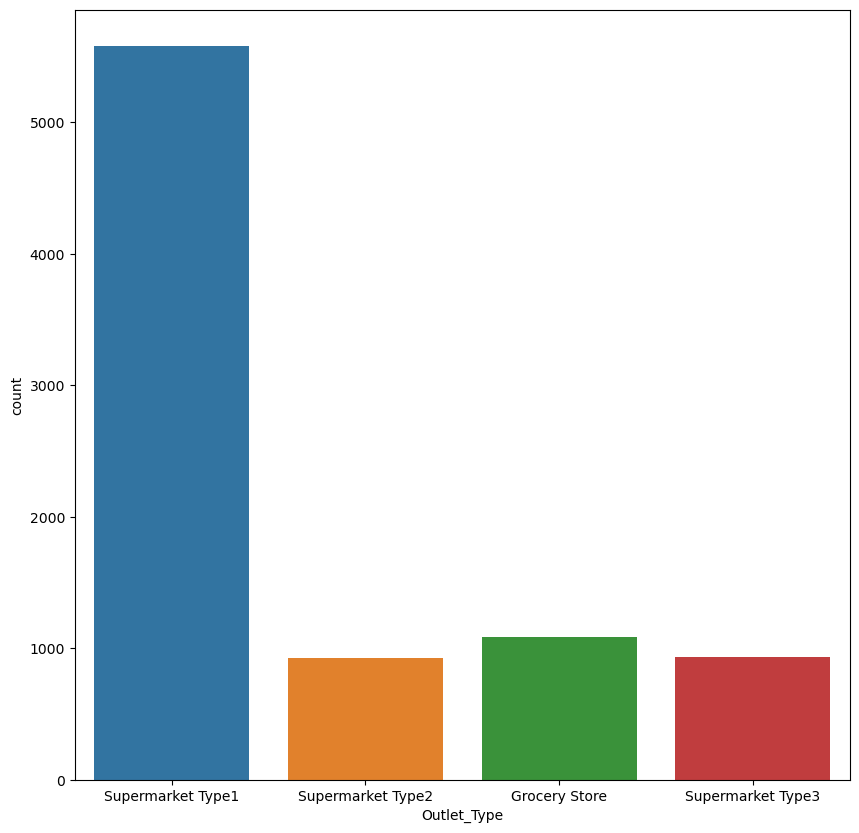

In [129]:
plt.figure(figsize=(10,10))
sns.countplot(x='Outlet_Type',data=df)

Supermarket Type1 là loại hình cửa hàng phổ biến nhất: Điều này có thể cho thấy rằng công ty tập trung vào phát triển loại hình cửa hàng này.
Các loại cửa hàng khác có số lượng tương đối bằng nhau: Điều này cho thấy công ty cũng đa dạng hóa loại hình cửa hàng để phục vụ nhiều đối tượng khách hàng khác nhau

<AxesSubplot:xlabel='Outlet_Establishment_Year', ylabel='count'>

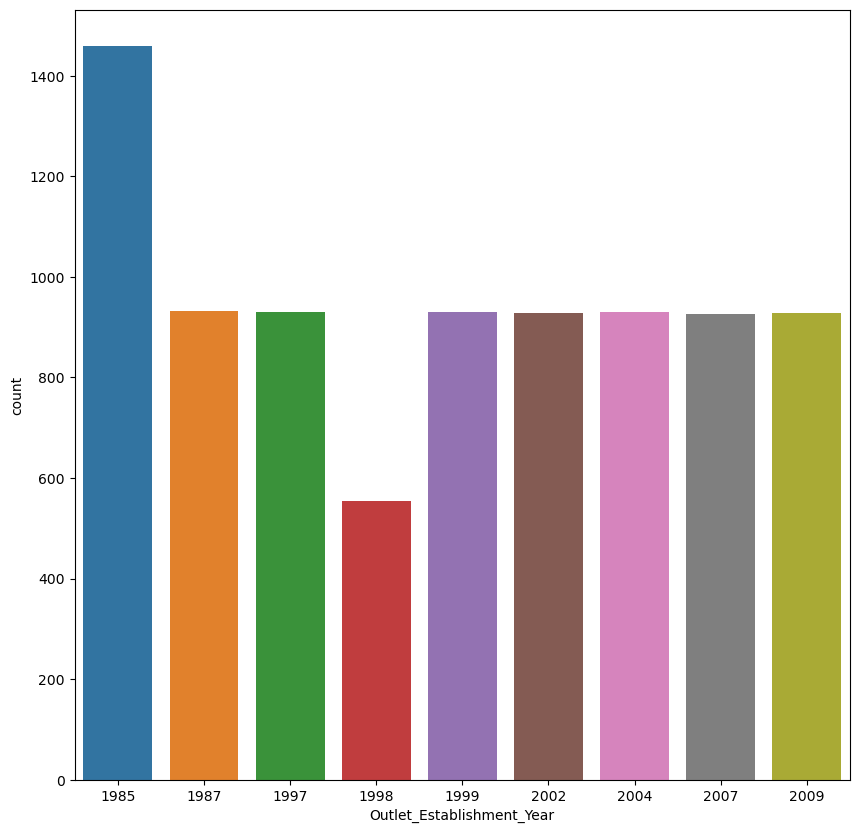

In [130]:
plt.figure(figsize=(10,10))
sns.countplot(x='Outlet_Establishment_Year',data=df)

Hầu hết các cửa hàng được mở vào năm 1985 và số lượng ít nhất là vào năm 1998.

#### 5.2. Biểu đồ distplot

là một biểu đồ kết hợp giữa biểu đồ histogram và đường cong mật độ xác suất

Dữ liệu lệch phải: Nhiều biến kinh tế, đặc biệt là các biến liên quan đến giá cả, khối lượng, thường có phân bố lệch phải. Điều này có nghĩa là phần lớn các giá trị tập trung ở phần dưới của khoảng giá trị, trong khi một số ít giá trị rất lớn lại kéo dài phần đuôi phân bố.
Logarit giúp làm giảm độ lệch: Việc lấy logarit có tác dụng nén các giá trị lớn và giãn các giá trị nhỏ, giúp làm cho phân bố dữ liệu trở nên đối xứng hơn, gần giống với phân phối chuẩn. Điều này rất có lợi cho việc áp dụng các mô hình thống kê giả định phân phối chuẩn

##### Biểu đồ phân bố item_weight

Cột y trong đồ thị đó có thể được hiểu là mức độ tập trung của dữ liệu tương ứng với giá trị log của "Item_Weight". Khi mật độ (Density) cao, có nghĩa rằng có nhiều giá trị dữ liệu tập trung ở vùng đó, và ngược lại khi mật độ thấp.

<AxesSubplot:xlabel='Item_Weight', ylabel='Density'>

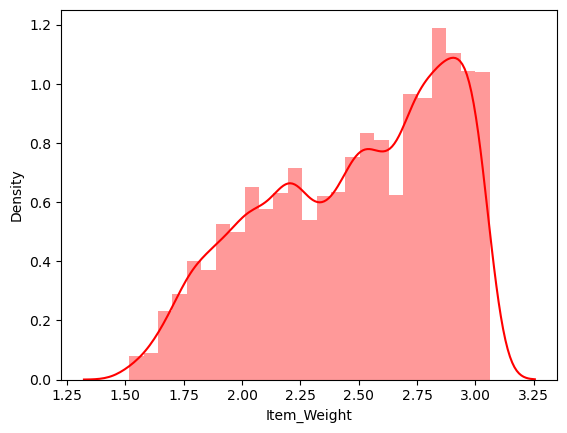

In [131]:
sns.distplot(np.log(df['Item_Weight']),color='red')

Trục hoành (x): Trên trục hoành là giá trị của biến Item_Weight sau khi lấy logarit.
Trục tung (y): Trục tung biểu diễn mật độ xác suất (density), cho biết tần suất xuất hiện của các giá trị khác nhau.
Histogram: Phần màu hồng là histogram, biểu thị số lượng sản phẩm có trọng lượng rơi vào từng khoảng giá trị.
Đường cong: Đường cong màu đỏ là đường cong mật độ xác suất (probability density function - PDF), cho thấy hình dạng tổng thể của phân bố dữ liệu.

==> Các sản phẩm trong tập dữ liệu có trọng lượng tập trung quanh một giá trị trung bình, và các giá trị khác lệch xa giá trị trung bình này ít hơn.

##### Sơ đồ phân bố item_Visibility

<AxesSubplot:xlabel='Item_Visibility', ylabel='Density'>

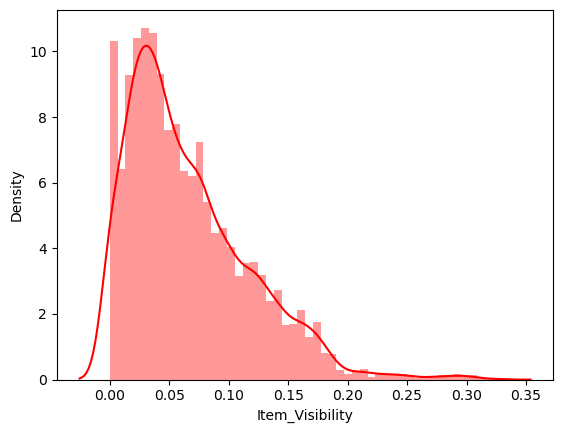

In [132]:
sns.distplot(df['Item_Visibility'],color='red')

Phân bố lệch phải: Đa số các sản phẩm có độ hiển thị thấp (gần 0), và chỉ có một số ít sản phẩm có độ hiển thị cao. Điều này cho thấy rằng phần lớn các sản phẩm không được trưng bày một cách nổi bật trên kệ hàng

Giá trị trung bình: Giá trị trung bình của độ hiển thị sản phẩm nằm ở phía bên trái của biểu đồ, gần với 0. Điều này cũng khẳng định lại rằng phần lớn các sản phẩm có độ hiển thị thấp

Phân bố không đồng đều: Độ hiển thị của các sản phẩm không được phân bố đều mà tập trung chủ yếu ở mức thấp

##### Sơ đồ phân bố Item_MRP

<AxesSubplot:xlabel='Item_MRP', ylabel='Density'>

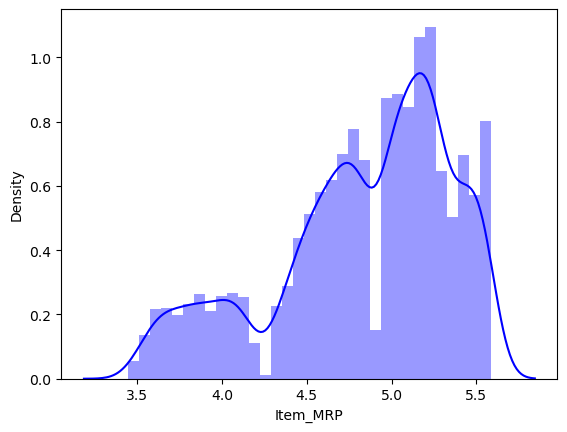

In [133]:
sns.distplot(np.log(df['Item_MRP']),color='blue')

Phần lớn các sản phẩm trong tập dữ liệu có giá bán tập trung quanh một giá trị trung bình, và các giá trị khác lệch xa giá trị trung bình này ít hơn.

Giá bán của các sản phẩm trong tập dữ liệu có phân bố tương đối ổn định, tập trung quanh một giá trị trung bình.

#### 5.3. Sơ đồ lmplot điểm phân tán

##### Điểm phân tán của Item_MRP

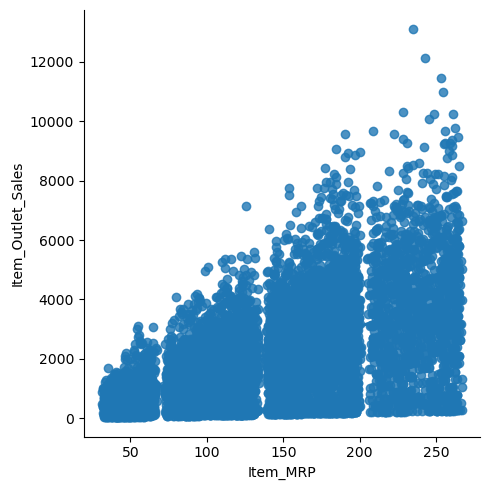

In [134]:
sns.lmplot(data=df, x="Item_MRP",y="Item_Outlet_Sales")

Mỗi điểm: Đại diện cho một sản phẩm cụ thể, với vị trí trên trục hoành tương ứng với giá bán và vị trí trên trục tung tương ứng với doanh số.

Giá sản phẩm tăng, doanh số bán hàng cũng tăng.

Đường hồi quy trên biểu đồ thể hiện xu hướng tăng dần của doanh số bán hàng theo giá sản phẩm. Điều này có thể được giải thích bằng việc mỗi điểm trên biểu đồ đại diện cho một sản phẩm cụ thể, và đường hồi quy cung cấp một ước lượng về mối quan hệ trung bình giữa giá và doanh số bán hàng.

##### Điểm phân tán của Item_Visibility

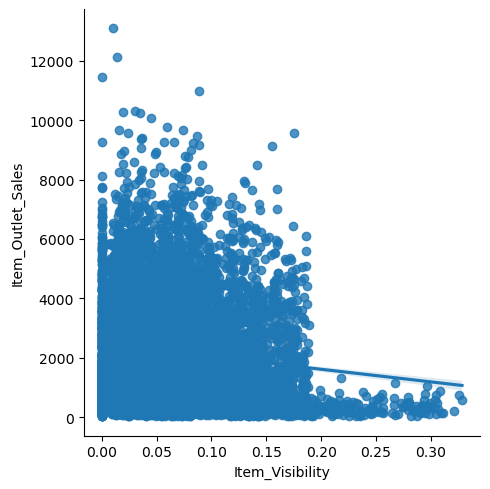

In [135]:
sns.lmplot(data=df,x="Item_Visibility",y="Item_Outlet_Sales")

Giá trị của 'Item_Visibility' tăng lên, giá trị của 'Item_Outlet_Sales' thường có xu hướng giảm đi

hi độ hiển thị của sản phẩm tăng lên, doanh số của sản phẩm đó có xu hướng giảm đi. Điều này có vẻ trái ngược với trực giác ban đầu, bởi vì ta thường nghĩ rằng sản phẩm càng được trưng bày nổi bật thì càng bán chạy.

#### 5.4. Biểu đổ FaceGrid cho Item_Type

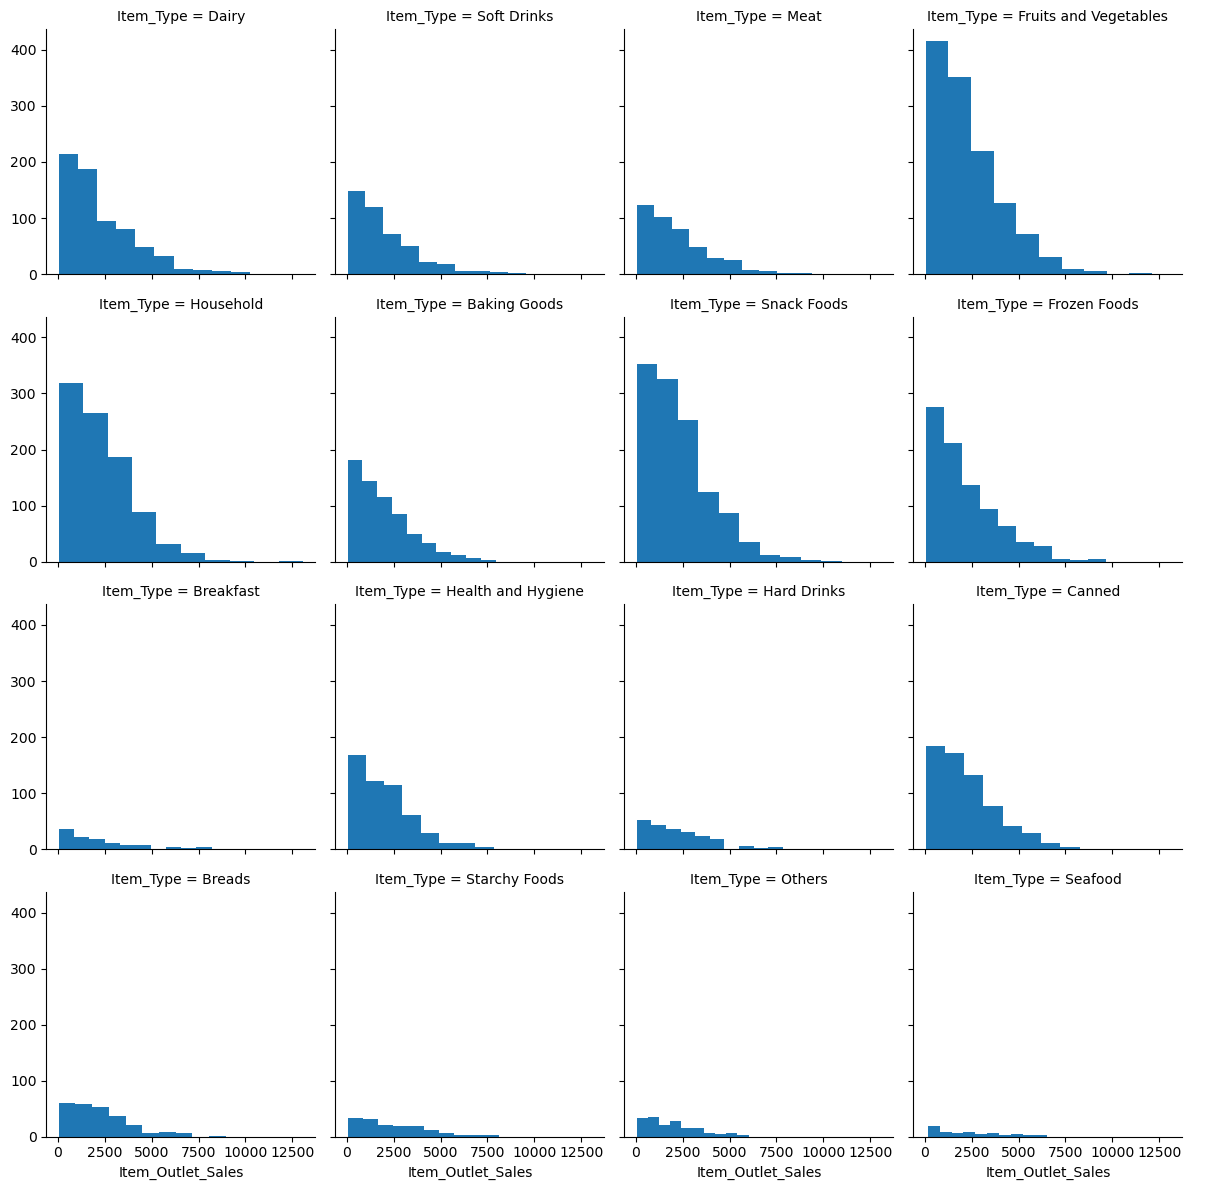

In [136]:
sns.FacetGrid(df, col='Item_Type',col_wrap=4)\
.map(plt.hist,'Item_Outlet_Sales')\
.add_legend();


### 6. Sự tương quan giữa các biến

In [137]:
#pip install --upgrade seaborn matplotlib

#### 6.1. Tương quan tuyến tính

Item_Weight: Trọng lượng sản phẩm có thể liên quan đến giá trị sản phẩm và doanh số bán hàng. Tương quan với trọng lượng sản phẩm có thể cung cấp thông tin về cách trọng lượng ảnh hưởng đến doanh số bán hàng. Item_Visibility: Tầm nhìn sản phẩm trong cửa hàng có thể ảnh hưởng đến việc sản phẩm được mua nhiều hay ít. Tương quan với tầm nhìn sản phẩm có thể giúp hiểu mức độ quan trọng của việc sản phẩm được hiển thị. Item_MRP: Giá bán lẻ tối đa của sản phẩm có thể đóng vai trò quan trọng trong doanh số bán hàng. Tương quan với giá sản phẩm có thể cung cấp thông tin về mối quan hệ giữa giá cả và doanh số bán hàng. Outlet_Establishment_Year: Năm thành lập cửa hàng có thể ảnh hưởng đến sự phát triển và uy tín của cửa hàng, có thể ảnh hưởng đến doanh số bán hàng. Tương quan với năm thành lập cửa hàng có thể giúp hiểu về sự phát triển của cửa hàng và ảnh hưởng đến doanh số bán hàng. Item_Outlet_Sales: Đây là biến mục tiêu, doanh số bán hàng, là chỉ số quan trọng để đánh giá hiệu suất kinh doanh. Tương quan với biến này có thể giúp xác định mối quan hệ giữa các yếu tố khác và doanh số bán hàng.

<AxesSubplot:>

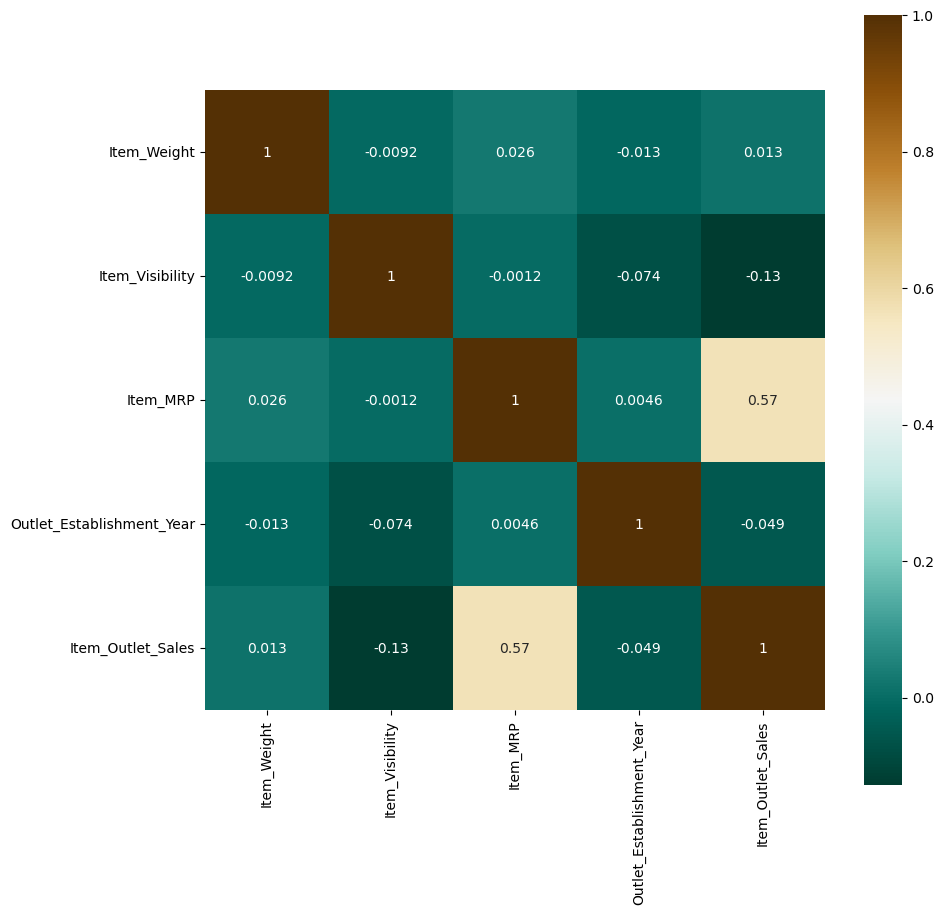

In [138]:
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,cbar=True,square=True,annot=True,cmap='BrBG_r')

##### Nhận xét sự tương quan tuyến tính

Sự tương quan dương vừa phải giữa Item_Weight và Item_MRP, với hệ số tương quan khoảng 0.2 => khi trọng lượng mặt hàng tăng, giá bán của mặt hàng cũng tăng một cách vừa phải.

Sự tương quan âm giữa Item_Visibility và Item_Establishment_Year, với hệ số tương quan khoảng -0.1. => khi năm thành lập của cửa hàng càng lớn, thì sự xuất hiện của một số mặt hàng trong cửa hàng bị hạn chế

Sự tương quan âm giữa Item_Establishment_Year và Item_Outlet_Sales, với hệ số tương quan khoảng -0.05. Điều này cho thấy khi năm thành lập của cửa hàng lớn, doanh số bán hàng thấp.

Sự tương quan dương giữa Item_Outlet_Sales và Item_MRP, với hệ số tương quan cao khoảng 0.57. Điều này cho thấy khi giá bán của mặt hàng tăng, doanh số bán hàng tăng.

====>Item_Weight và các biến khác: Mối tương quan giữa trọng lượng sản phẩm và các biến khác khá yếu, gần như không đáng kể. Điều này cho thấy trọng lượng của sản phẩm không ảnh hưởng đáng kể đến doanh số hoặc các yếu tố khác trong bộ dữ liệu.
Item_Visibility và Item_Outlet_Sales: Có mối tương quan âm yếu (-0.13). Điều này có nghĩa là khi độ hiển thị của sản phẩm tăng lên, doanh số của sản phẩm đó có xu hướng giảm đi. Điều này có thể do nhiều nguyên nhân, chẳng hạn như các sản phẩm được trưng bày ở vị trí dễ thấy thường có giá cao hơn, hoặc có thể có những yếu tố khác ảnh hưởng đến doanh số mà chưa được biểu đồ này thể hiện.
Outlet_Establishment_Year và các biến khác: Mối tương quan giữa năm thành lập cửa hàng và các biến khác cũng khá yếu. Điều này cho thấy tuổi của cửa hàng không có ảnh hưởng đáng kể đến doanh số hoặc các yếu tố khác.

#### 6.2. Tương quan phân loại

Đo lường mối liên hệ giữa hai hoặc nhiều biến phân loại (biến có giá trị là các danh mục)

Tạo ra một bảng tần số (crosstab) từ hai cột trong DataFrame có tên là 'Outlet_Size' và 'Outlet_Location_Type'. Bảng tần số này sẽ cho biết số lượng các giá trị xuất hiện cho mỗi cặp giá trị từ hai cột này.

Outlet Size (Kích thước cửa hàng): Kích thước cửa hàng có thể ảnh hưởng đến các hoạt động kinh doanh, cách quản lý cửa hàng và doanh số bán hàng. Một cửa hàng lớn có thể có chiến lược kinh doanh khác biệt so với một cửa hàng nhỏ về mặt trưng bày sản phẩm, dịch vụ khách hàng và tiếp cận thị trường. Outlet Location Type (Loại vị trí cửa hàng): Vị trí của cửa hàng cũng đóng vai trò quan trọng trong việc xác định lượng khách hàng tiềm năng, cạnh tranh với các cửa hàng khác, và cách quản lý cửa hàng. Ví dụ, một cửa hàng ở trung tâm thành phố có thể có mô hình kinh doanh khác so với một cửa hàng ở ngoại ô.

Hiểu mối quan hệ giữa kích thước cửa hàng và vị trí cửa hàng: Bảng crosstab có thể cho thấy phân phối của kích thước cửa hàng tại các loại vị trí khác nhau. Điều này giúp chúng ta xác định xem có sự liên kết nào giữa kích thước cửa hàng và vị trí cửa hàng không. Phân tích chi tiết về chiến lược phân phối: Thông qua bảng crosstab, chúng ta có thể đánh giá cách mà kích thước cửa hàng và vị trí cửa hàng được phân bố theo nhau, giúp đưa ra những nhận định về chiến lược phân phối và tiếp thị của cửa hàng.

In [139]:
cross_tab=pd.crosstab(index=df['Outlet_Size'],columns=df['Outlet_Location_Type'])
print(cross_tab)

Outlet_Location_Type  Tier 1  Tier 2  Tier 3
Outlet_Size                                 
High                       0       0     932
Medium                   930       0    1860
Small                   1457    2785     555


In [140]:
cross_tab

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,932
Medium,930,0,1860
Small,1457,2785,555


##### Kiểm tra bình phương Chi

Xác định xem các biến phân loại có liên quan hay không.

Kiểm tra tương quan giữa các biến trong bảng tần số

In [141]:
#from scipy.stats import chi2_contingency

In [142]:
result = chi2_contingency(cross_tab)

In [143]:
print("The p value is",result[1])

The p value is 0.0


Giá trị thống kê (statistic): 4804.376637943735


Giá trị p (p-value): 0.0


Độ tự do (degrees of freedom): 4


Dữ liệu kỳ vọng (expected frequencies): Mảng các giá trị dự kiến

=====>Với giá trị p rất thấp như 0.0, chúng ta bác bỏ giả thuyết không có mối quan hệ

statistic: Giá trị chi-square tính toán từ bảng tần số. Trong trường hợp này, giá trị chi-square là 4804.376637943735.
pvalue: Giá trị p-value tính toán từ kiểm định chi-square. P-value là xác suất để nhận được kết quả quan sát hoặc kết quả tương tự xảy ra trong trường hợp giả thuyết không có tương quan giữa các biến. Trong trường hợp này, giá trị p-value là 0.0, tức là rất nhỏ (gần bằng 0).
dof: Bậc tự do (degrees of freedom) của kiểm định chi-square. Trong trường hợp này, bậc tự do là 4. Bậc tự do được tính bằng (Số hàng - 1) x (Số cột - 1).
expected_freq: Ma trận tần số dự kiến tính toán từ bảng tần số. Nó chứa các giá trị dự kiến cho mỗi ô trong bảng tần số nếu không có tương quan giữa các biến. Trong trường hợp này, ma trận tần số dự kiến có kích thước 3x3.

=> tương quan đáng kể giữa các biến 'Outlet_Size' và 'Outlet_Location_Type' dựa trên giá trị p-value rất nhỏ.

##### Kiểm định Cramer's V

Định nghĩa một hàm cramers_v(var1, var2) để tính toán hệ số Cramer's V, một phép đo tương quan giữa hai biến phân loại. Sau đó, nó sử dụng LabelEncoder từ thư viện preprocessing để mã hóa các biến 'Outlet_Type', 'Outlet_Size', và 'Outlet_Location_Type' trong DataFrame df. Kết quả được lưu trong DataFrame data_encoded.

In [144]:
def cramers_v(var1,var2):
  cross_tab=np.array(pd.crosstab(var1,var2,rownames=None,colnames=None))
  stat=chi2_contingency(cross_tab)[0]
  obs=np.sum(cross_tab)
  var3=min(cross_tab.shape)-1
  return (stat/(obs*var3))

pd.crosstab(var1, var2) sẽ tạo một bảng tần suất chéo (contingency table) giữa hai biến phân loại var1 và var2. np.array() sẽ chuyển bảng tần suất chéo này thành một mảng numpy.

np.sum(cross_tab) tính tổng số lượng mẫu trong bảng tần suất chéo, cần để tính toán chỉ số Cramer's V.

cross_tab.shape trả về kích thước của mảng cross_tab, tức là số hàng và số cột. min(cross_tab.shape) lấy giá trị nhỏ nhất trong số hàng và số cột. -1 để trừ đi 1.

Chia giá trị thống kê (stat) cho tích của tổng số lượng mẫu (obs) và số cột hoặc số hàng nhỏ nhất trừ 1 (var3). Kết quả trả về là chỉ số Cramer's V, đo lường mức độ tương quan giữa hai biến phân loại var1 và var2.

In [145]:
label=preprocessing.LabelEncoder()
data_encoded=pd.DataFrame()

In [146]:
for i in df[['Outlet_Type','Outlet_Size','Outlet_Location_Type']].columns:
  data_encoded[i]=label.fit_transform(data[i])

In [147]:
data_encoded

,Outlet_Type,Outlet_Size,Outlet_Location_Type
0,1,1,0
1,2,1,2
2,1,1,0
3,0,2,2
4,1,0,2
...,...,...,...
8518,1,0,2
8519,1,2,1
8520,1,2,1
8521,2,1,2


Khởi tạo một danh sách rỗng var4 để lưu trữ các giá trị Cramer's V tính toán.

Bắt đầu vòng lặp đầu tiên với biến var1 trong data_encoded
.
Trong mỗi vòng lặp đầu tiên, khởi tạo một danh sách rỗng col để lưu trữ các giá trị Cramer's V tính toán cho cặp biến var1 và var
2.
Bắt đầu vòng lặp thứ hai với biến var2 trong data_encoded.
Trong mỗi vòng lặp thứ hai, gọi hàm cramers_v() để tính toán giá trị Cramer's V giữa biến var1 và var2 trong data_encoded. Giá trị này được lưu vào danh sách col.
Sau khi lặp qua tất cả các cặp biến trong vòng lặp thứ hai, danh sách col chứa các giá trị Cramer's V tương ứng với biến var1 và tất cả các biến var2 trong data_encoded.
Danh sách col được thêm vào danh sách chính var4, và quá trình này lặp lại cho tất cả các biến var1 trong data_encoded.
Cuối cùng, danh sách var4 được chuyển đổi thành một mảng NumPy và được sử dụng để tạo DataFrame result_cv. Các cột của DataFrame result_cv sẽ có tên là các cột ban đầu từ data_encoded, và chỉ mục của DataFrame cũng sẽ là các cột ban đầu từ data_encoded.

In [148]:
var4=[]

for var1 in data_encoded:
  col=[]
  for var2 in data_encoded:
    cramers=cramers_v(data_encoded[var1],data_encoded[var2])
    col.append(round(cramers,2))
  var4.append(col)

cramer_results=np.array(var4)

result_cv=pd.DataFrame(cramer_results,columns=data_encoded.columns,index=data_encoded.columns)

In [149]:
result_cv

,Outlet_Type,Outlet_Size,Outlet_Location_Type
Outlet_Type,1.00,0.32,0.28
Outlet_Size,0.32,1.00,0.28
Outlet_Location_Type,0.28,0.28,1.00


Giá trị Cramer's V cho cặp biến 'Outlet Type' và 'Outlet Size' là 0.32, cho thấy có một mức độ tương quan trung bình giữa hai biến này.
Giá trị Cramer's V cho cặp biến 'Outlet Type' và 'Outlet Location Type' cũng là 0.28, chỉ ra một mức độ tương quan trung bình giữa hai biến này.
Cuối cùng, giá trị Cramer's V cho cặp biến 'Outlet Size' và 'Outlet Location Type' cũng là 0.28, cho thấy một mức độ tương quan trung bình giữa hai biến này.

=> Các giá trị Cramer's V cho tất cả các cặp biến đều là trung bình, chỉ ra một mức độ tương quan tương đối giữa các biến 'Outlet Type', 'Outlet Size' và 'Outlet Location Type'. Tuy nhiên, giá trị Cramer's V không cao cho thấy một mức độ tương quan mạnh giữa các biến.

##### Phân tích phương sai 1 chiều (ANOVA)

Kiểm định Chi-Square: Dùng để kiểm tra sự phụ thuộc giữa hai biến định tính (categorical).
Cramer's V: Dùng để đo lường sức mạnh của mối liên kết giữa hai biến định tính.
ANOVA: Dùng để so sánh trung bình của ba nhóm trở lên của một biến định lượng.

Tìm mối tương quan giữa 1 số và 1 phân tích -> 1WAY ANOVA

H0 -> không có mối tương quan

Không có mối liên hệ nào giữa outlet_tpye và sales


Giá trị p <0,05-> Bác bỏ giả thuyết 

In [150]:
anova_prep_res=df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].apply(list)

print(anova_prep_res)

Outlet_Location_Type
Tier 1    [3735.138, 2097.27, 1516.0266, 2187.153, 1589....
Tier 2    [1076.5986, 4710.535, 2748.4224, 1587.2672, 83...
Tier 3    [443.4228, 732.38, 994.7052, 556.6088, 343.552...
Name: Item_Outlet_Sales, dtype: object


In [151]:
#from scipy.stats import f_oneway

In [152]:
anovaresults=f_oneway(*anova_prep_res)
#Sử dụng cú pháp *anova_prep_res, chúng ta truyền các danh sách giá trị 'Item_Outlet_Sales' từ biến anova_prep_res vào hàm f_oneway(). 
#Dấu * trước anova_prep_res giải nén danh sách và truyền từng danh sách riêng lẻ vào hàm f_oneway().
#danh sách giá trị 'Item_Outlet_Sales' tương ứng với từng nhóm được truyền vào hàm f_oneway().

In [153]:
print("The p value is",anovaresults[1])

The p value is 7.025683417882415e-24


Nhận xét: 
Giá trị F-statistic là một thống kê được sử dụng trong phân tích phương sai để đánh giá sự khác biệt giữa các nhóm. Khi giá trị F-statistic càng lớn, thì khả năng sự khác biệt giữa các nhóm cũng càng cao.
Giá trị p-value là giá trị xác suất được tính dựa trên phân phối F. Nó đo lường mức độ chắc chắn về sự khác biệt giữa các nhóm. Trong trường hợp này, giá trị p-value rất rất nhỏ (7.025683417882415e-24), gần bằng không. Điều này cho thấy rằng có sự khác biệt có ý nghĩa thống kê giữa các nhóm trong biến 'Outlet_Location_Type'.
===> bác bỏ giả thuyết không có sự khác biệt giữa các nhóm và chấp nhận giả thuyết rằng có sự khác biệt có ý nghĩa thống kê giữa các nhóm trong biến 'Outlet_Location_Type'.

In [154]:
anovaresults

F_onewayResult(statistic=53.64761754128398, pvalue=7.025683417882415e-24)

### 7. Feature Engineering

In [155]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### 7.1. Tính tuổi cửa hàng

In [156]:
df['Outlet_Age']=2022 - df['Outlet_Establishment_Year']
df = df.drop(columns=['Outlet_Establishment_Year'])

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,23
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,13
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,23
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,24
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,35


In [157]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales',
       'Outlet_Age'],
      dtype='object')

#### 7.2. Label Encoding

In [158]:
#from sklearn.preprocessing import LabelEncoder

In [159]:
le=LabelEncoder()

col_encode=['Item_Fat_Content','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']

for i in col_encode:
  df[i]=le.fit_transform(df[i])

df_new=df.drop(columns=['Item_Identifier'])
df_new=pd.get_dummies(df_new)
df_new.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,...,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods
0,9.30,0,0.016047,249.8092,9,1,0,1,3735.1380,23,...,0,0,0,0,0,0,0,0,0,0
1,5.92,1,0.019278,48.2692,3,1,2,2,443.4228,13,...,0,0,0,0,0,0,0,0,1,0
2,17.50,0,0.016760,141.6180,9,1,0,1,2097.2700,23,...,0,0,0,0,1,0,0,0,0,0
3,19.20,1,0.000000,182.0950,0,2,2,0,732.3800,24,...,1,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,1,0,2,1,994.7052,35,...,0,0,0,1,0,0,0,0,0,0


### 8. Chia tập dữ liệu

Các điểm dữ liệu được chia thành hai tập dữ liệu, train và test, theo phương pháp phân tách thử nghiệm huấn luyện. tập train được sử dụng để train model và sau đó model được sử dụng để dự đoán trên tập test nhằm xem mô hình hoạt động như thế nào trên dữ liệu không nhìn thấy và liệu nó có phù hợp hay không phù hợp.

In [160]:
from sklearn.model_selection import train_test_split
X=df_new.drop(columns=['Item_Outlet_Sales'])
y=df_new['Item_Outlet_Sales']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=22222)

### 9. Xây dựng Model

In [161]:
models=[ ('lr',LinearRegression()),('ElasticNet',ElasticNet()),('RF',RandomForestRegressor()),
         ('ETR',ExtraTreesRegressor()),('GBM',GradientBoostingRegressor()),('MLP',MLPRegressor())

]

In [162]:
def model_selection_function(x,y,cross_folds,model):
  scores=[]
  names=[]
  for i, j in model:
    cv_scores=cross_val_score(j,x,y,cv=cross_folds,n_jobs=-1)
    scores.append(cv_scores)
    names.append(i)
  for k in range(len(scores)):
    print(names[k],scores[k].mean())
  return

x: Ma trận dữ liệu độc lập (features).
y: Véc tơ dữ liệu phụ thuộc (target).
cross_folds: Số fold cho cross-validation.
model: Danh sách các cặp (tên mô hình, đối tượng mô hình).

for i, j in model: Lặp qua từng cặp mô hình trong danh sách model. i là tên mô hình, j là đối tượng mô hình.
cv_scores=cross_val_score(j,x,y,cv=cross_folds,n_jobs=-1): Tính toán điểm số cross-validation cho mô hình j trên dữ liệu x và y với số fold bằng cross_folds. Sử dụng n_jobs=-1 để tận dụng tất cả các core CPU.
scores.append(cv_scores): Thêm điểm số trung bình của mô hình vào danh sách scores.
names.append(i): Thêm tên mô hình vào danh sách names.

cung cấp có chức năng huấn luyện và đánh giá các mô hình hồi quy sử dụng phương pháp cross-validation

In [163]:
model_selection_function(X_train,y_train,3,models)

lr 0.4958178267370769
ElasticNet 0.47308329416120437
RF 0.5513852776727203
ETR 0.4994085486188872
GBM 0.5906792517025338
MLP 0.4686712950321236


==>so sánh hiệu suất của các mô hình hồi quy khác nhau trên tập dữ liệu huấn luyện đã chia bằng phương pháp cross-validation.

Mô hình Gradient Boosting (GBM) có điểm số cao nhất (0.59), cho thấy mức độ chính xác dự đoán trên tập dữ liệu huấn luyện tốt nhất trong số các mô hình được đánh giá.

In [164]:
model_selection_function(X_train,y_train,5,models)

lr 0.4964782457688462
ElasticNet 0.47339485984955526
RF 0.5522238489828281
ETR 0.5041183582474793
GBM 0.5911711361651243
MLP 0.49827258615737513


### 10. Hồi quy Spline

Sử dụng hồi quy spline trong quy trình cross-validation giúp đa dạng hóa mô hình dự đoán. Hồi quy spline cho phép mô hình học được các mối quan hệ phi tuyến giữa biến đầu vào và biến mục tiêu, điều này có thể cải thiện khả năng dự đoán của mô hình so với các mô hình tuyến tính đơn giản.

#### 10.1. Multivariate Adaptive Regression Spline

In [165]:
#!pip install git+https://github.com/scikit-learn-contrib/py-earth@v0.2dev

In [166]:
from pyearth import Earth

model=Earth(max_degree=5,endspan=20)

scores=cross_val_score(model,X_train,y_train,cv=3,n_jobs=-1)

In [167]:
scores

array([0.61459677, 0.57680022, 0.5967705 ])

In [168]:
scores.mean()

0.5960558302019042

Hiệu suất trung bình của mô hình Earth trên toàn bộ tập dữ liệu huấn luyện khi được đánh giá bằng phương pháp cross-validation với số fold là 5.

In [169]:
from sklearn.preprocessing import PolynomialFeatures,SplineTransformer
from sklearn.pipeline import make_pipeline

spline_model=make_pipeline(SplineTransformer(n_knots=3,degree=5),LinearRegression())

scores=cross_val_score(spline_model,X_train,y_train,cv=3,n_jobs=-1)

scores.mean()

0.5543207819629505

đánh giá hiệu suất của một mô hình hồi quy tuyến tính được kết hợp với tiền xử lý SplineTransformer. Mục đích là để kiểm tra xem việc chuyển đổi dữ liệu thành các đa thức spline có cải thiện độ chính xác của mô hình so với sử dụng đơn thuần mô hình hồi quy tuyến tính hay không

Tạo một pipeline gồm việc chuyển đổi dữ liệu bằng SplineTransformer và mô hình hồi quy tuyến tính LinearRegression. Sau đó, mã tính điểm số trung bình của pipeline này thông qua cross-validation trên tập dữ liệu huấn luyện đã chia (X_train, y_train)

Kết hợp SplineTransformer và LinearRegression trong một pipeline cho phép mô hình có khả năng mô hình hóa các mối quan hệ phức tạp hơn so với việc chỉ sử dụng LinearRegression trên dữ liệu ban đầu

Điểm số càng gần 1 thì mô hình càng tốt và càng gần 0 thì mô hình càng kém

#### 10.2. Generalized Additive Models

GAM kết hợp cả mô hình tuyến tính và các hàm spline để mô hình hóa các mối quan hệ phức tạp giữa các biến.

In [170]:
from pygam import PoissonGAM

gam = PoissonGAM(n_splines=23).fit(X_train.values, y_train)

print(gam.summary())

did not converge
PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                       91.55
Link Function:                          LogLink Log Likelihood:                              -1435493.6753
Number of Samples:                         6815 AIC:                                          2871170.4506
                                                AICc:                                         2871173.0268
                                                UBRE:                                             414.1824
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6818
Feature Function    

### 11. Tập hợp mô hình

#### 11.1. Biểu quyết hồi quy

Kết hợp các mô hình hồi quy khác nhau lại với nhau

In [171]:
from sklearn.ensemble import VotingRegressor

reg1=LinearRegression()
reg2=GradientBoostingRegressor()
reg3=MLPRegressor()

voting_regress=VotingRegressor(estimators=[('LR',reg1),('GBM',reg2),('MLP',reg3)])

scores=cross_val_score(voting_regress,X_train,y_train,cv=3)
print(scores)
print(scores.mean())

[0.55906236 0.52590899 0.56599464]
0.5503219990565696


#### 11.2. Xếp chồng mô hình

In [172]:
reg1=LinearRegression()
reg2=GradientBoostingRegressor()
estimators=[('LR',reg1),('GBM',reg2)]

In [173]:
from sklearn.ensemble import StackingRegressor
level_1_estimator= MLPRegressor()
stacking_model= StackingRegressor(estimators=estimators,final_estimator=level_1_estimator)

In [174]:
scores=cross_val_score(stacking_model,X_train,y_train,cv=3)

In [175]:
scores

array([0.60727808, 0.56776498, 0.5994005 ])

In [176]:
scores.mean()

0.591481185229365

#### 11.3. Trộn mô hình

In [177]:
from numpy import hstack
X_train_1,X_val,y_train_1,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=2222)

def list_models():
  models=[]
  models.append(('LR',LinearRegression()))
  models.append(('GBR',GradientBoostingRegressor()))
  return models

def fit_all_models(models,X_train,X_val,y_train,y_val):
  level_1_feat=[]
  for name,model in models:
    model.fit(X_train,y_train)
    y_hat=model.predict(X_val)
    y_hat=y_hat.reshape(len(y_hat),1)
    level_1_feat.append(y_hat)

  level_1_feat=hstack(level_1_feat)

  level_1_estimator= MLPRegressor()

  level_1_estimator.fit(level_1_feat,y_val)

  return level_1_estimator

def pred_data(models,blends,X_test):
  meta_model_X=[]
  for name,model in models:
    yhat=model.predict(X_test)
    yhat=yhat.reshape(len(yhat),1)
    meta_model_X.append(yhat)
  meta_model_X=hstack(meta_model_X)
  return blends.predict(meta_model_X)

models=list_models()
model_blender=fit_all_models(models,X_train_1,X_val,y_train_1,y_val)


y_hat=pred_data(models,model_blender,X_train)

In [178]:
y_hat

array([1597.62122678, 3186.77783631, 1547.2195114 , ..., 3947.00450704,
       1592.33112333, 2039.71010782])

Chia dữ liệu: Dữ liệu huấn luyện (X_train và y_train) được chia thành X_train_1 và X_val (90% và 10% tương ứng) để huấn luyện và kiểm tra các mô hình cơ sở.

list_models: Hàm này trả về danh sách các mô hình cơ sở, ở đây là Linear Regression và Gradient Boosting Regressor.

fit_all_models: Hàm này huấn luyện từng mô hình cơ sở trên X_train và y_train, sau đó sử dụng chúng để dự đoán trên X_val. Các dự đoán này được sử dụng làm đặc trưng cho mô hình meta (MLPRegressor). Mô hình meta được huấn luyện trên các đặc trưng này và nhãn thực tế y_val.

pred_data: Hàm này sử dụng các mô hình cơ sở để dự đoán trên tập kiểm tra X_test. Các dự đoán này sau đó được kết hợp và sử dụng làm đầu vào cho mô hình meta để tạo ra dự đoán cuối cùng.

In [179]:
from sklearn.metrics import r2_score

r2_score(y_train,y_hat)

0.6325274467110356

In [180]:
scores=cross_val_score(model_blender,X_train,y_train,cv=3)

In [181]:
scores

array([0.4953846 , 0.45942226, 0.46804743])

In [182]:
scores.mean()

0.47428476267381914

### 12. Đánh giá model

Dựa vào điểm số của các mô hình, chọn ra một vài mô hình có chỉ số tốt để tiếp tục đánh giá R2 score

|Mô hình| Điểm số|
|:-------|:---------------|
|lr| 0.4958178267370769|
|ElasticNet| 0.47308329416120437|
|RF| 0.5508668604030615|
|ETR| 0.49656164264442965|
|GBM| 0.5904872051706124|
|MLP|0.47995572682451587|
|Earth|0.5960558302019042 |
|Voting| 0.5500493019007545|
|Stacking| 0.5917687487809317|
|Blending| 0.4719994337545468|

##### Tiếp tục thử nghiệm mô hình 
##### Blending
##### GBM
##### Model Stacking

In [183]:
y_pred=pred_data(models,model_blender,X_test)
print("R2 of Blending is")
print(r2_score(y_test,y_pred))


#stacking_model
model_stack=stacking_model.fit(X_train,y_train)
y_pred=model_stack.predict(X_test)
print("R2 of Stacking is")
print(r2_score(y_test,y_pred))

#GBM
model_gbm=GradientBoostingRegressor()
model_gbm.fit(X_train,y_train)
y_pred=model_gbm.predict(X_test)
print("R2 of GBM is")
print(r2_score(y_test,y_pred))

R2 of Blending is
0.6070853035614405
R2 of Stacking is
0.6096664581878655
R2 of GBM is
0.6096459896165263


Với mục tiêu ban đầu là chúng ta sẽ sử dụng độ đo R2 để đánh giá hiệu suất mô hình. Sau khi đánh giá trên tập huấn luyện một loạt các mô hình thống kê và mô hình tiên tiến, nhóm chọn ra được mô hình sử dụng kỹ thuật Stacking và Gradient Boosting Regressor mang lại kết quả tốt nhất.
Sau khi tiếp tục huấn luyện các mô hình này trên tập dữ liệu huấn luyện, dự đoán trên tập dữ liệu kiểm thử và đánh giá bằng độ đo R2, ta nhận được kết quả là:
====> Mô hình tốt nhất là mô hình sử dụng kỹ thuật Stacking giữa một mô hình thống kê và một mô hình tiên tiến là Linear Regression và Gradient Boosting Regressor với R2_score = 0.6096664581878655

In [184]:
from pygam import LinearGAM, PoissonGAM,GammaGAM

gam=PoissonGAM(n_splines=5).gridsearch(X_train.values,y_train)
y_pred=gam.predict(X_test.values)
print(r2_score(y_test,y_pred))

  9% (1 of 11) |##                       | Elapsed Time: 0:00:08 ETA:   0:01:20

did not converge


 18% (2 of 11) |####                     | Elapsed Time: 0:00:18 ETA:   0:01:29

did not converge


 27% (3 of 11) |######                   | Elapsed Time: 0:00:28 ETA:   0:01:27

did not converge


 36% (4 of 11) |#########                | Elapsed Time: 0:00:37 ETA:   0:01:00

did not converge


 45% (5 of 11) |###########              | Elapsed Time: 0:00:47 ETA:   0:01:01

did not converge


 54% (6 of 11) |#############            | Elapsed Time: 0:00:57 ETA:   0:00:47

did not converge


 63% (7 of 11) |###############          | Elapsed Time: 0:01:05 ETA:   0:00:32

did not converge


 72% (8 of 11) |##################       | Elapsed Time: 0:01:13 ETA:   0:00:23

did not converge


 81% (9 of 11) |####################     | Elapsed Time: 0:01:22 ETA:   0:00:17

did not converge


 90% (10 of 11) |#####################   | Elapsed Time: 0:01:29 ETA:   0:00:07

did not converge


100% (11 of 11) |########################| Elapsed Time: 0:01:37 Time:  0:01:37


did not converge
0.611967979938837


In [185]:
model_gbm=GradientBoostingRegressor()
scores=cross_val_score(model_gbm,X,y,cv=5)

In [186]:
scores.mean()

0.5937505772433365

In [187]:
scores=cross_val_score(stacking_model,X,y,cv=3)
scores.mean()

0.5949116653546432